In [1]:
import os
import re
import math
import time
import torch

import librosa
import librosa.display
import itertools
import functools
import torchaudio
import torchvision
import torch.optim


import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from functools import partial
import torch.nn.functional as F
from torch.utils.data import DataLoader

import IPython.display as ipd

from einops import rearrange, reduce
from einops.layers.torch import Rearrange
from torch import nn, einsum
from inspect import isfunction



import torchaudio.transforms as T

import IPython.display as ipd
import sentencepiece as spm
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence


import torch.utils.data
from librosa.util import normalize
from scipy.io.wavfile import read
from librosa.filters import mel as librosa_mel_fn

import pickle
import soundfile as sf
from scipy import signal
from scipy.signal import get_window
from librosa.filters import mel

MAX_WAV_VALUE = 32768.0




In [2]:
is_cuda = torch.cuda.is_available()

device = torch.device('cuda:0' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda:0


In [4]:
cd ../

/data/code/kmkim


In [3]:
from hifi_gan import Generator as hifigan_vocoder
from omegaconf import OmegaConf

path_config = 'hifi_gan.json'
path_ckpt = 'g_02500000'

hifigan_config = OmegaConf.load(path_config)
vocoder = hifigan_vocoder(hifigan_config)

state_dict_g = torch.load(path_ckpt)
vocoder = vocoder.to(device)
vocoder.load_state_dict(state_dict_g['generator'])
vocoder.eval()

ModuleNotFoundError: No module named 'hifi_gan'

In [31]:
def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)


def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C


def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)
    # return torch.clamp(x, min=clip_val) * C


def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C


def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output


def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output


sr = 22050
n_fft = 1024
win_length = n_fft
hop_length = 256

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft=n_fft, num_mels=80, sampling_rate= sr, hop_size=hop_length, win_size=win_length, fmin=0, fmax=8000, center=False):
    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax) + '_' + str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)
    
    #print(y.shape) # 45237, 1 (1024-256)/2, (1024-256)/2
    y = torch.nn.functional.pad(y.unsqueeze(0), ((int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2))),
                                mode='reflect')
    y = y.squeeze(1)
    
    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True, return_complex = False) # return_complex =False

    spec = torch.sqrt(spec.pow(2).sum(-1) + (1e-9)) #???

    spec = torch.matmul(mel_basis[str(fmax) + '_' + str(y.device)], spec)
        
    spec = librosa.power_to_db(spec, ref=np.max, top_db = num_mels) ## dB 단위로 변형 numpy로 결과가 나옴
    

    spec = (spec / 80.0) + 1

    
    return torch.from_numpy(spec.astype("float32")) ## numpy를 torch로

In [32]:
def inference_to_audio(x, sr = 22050, n_mels = 80):
    
    inference_ = (x.cpu() - 1) * 80.0

    S = librosa.db_to_power(inference_)

    zxc = spectral_normalize_torch(S.squeeze()) ## 나온 power 정규화 필수
    
    conv_wav = vocoder(zxc.to(device)) 
    
    conv_wav = conv_wav.squeeze().detach().cpu().numpy()
    
    print(librosa.display.waveshow(conv_wav))
    
    return conv_wav

In [33]:
def collate_fn(batch):
    
    src_speech = [] 
    
    for samples, sr, text, speaker, idx in batch:                    
                
        resample_audio = torchaudio.functional.resample(samples, orig_freq=sr, new_freq=22050) ## [1,153600]
        
        rand_cut = resample_audio.shape[1] - 32802
        
        if rand_cut < 0:
            continue
        
        else:
            start_sample = torch.randint(0, rand_cut, (1,)).int().item()

        mel_spec = mel_spectrogram(resample_audio[0][start_sample:start_sample + 32802])
                
        src_speech.append(mel_spec.squeeze().permute(1,0)) 
        
    
    speech_batch = pad_sequence(src_speech, padding_value = 0.0, batch_first = True) # batch, Frame, mel
    
    speech_batch =speech_batch.permute(0,2,1)
    
    return speech_batch.unsqueeze(1) ## batch, 1, mel, time

In [34]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


def Upsample(dim, dim_out=None):
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode="nearest"),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1),
    )


def Downsample(dim, dim_out=None):
    # No More Strided Convolutions or Pooling
    return nn.Sequential(
        Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2),
        nn.Conv2d(dim * 4, default(dim_out, dim), 1),
    )

In [35]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [50]:
class WeightStandardizedConv2d(nn.Conv2d):
    """
    https://arxiv.org/abs/1903.10520
    weight standardization purportedly works synergistically with group normalization
    """

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3

        weight = self.weight
        mean = reduce(weight, "o ... -> o 1 1 1", "mean")
        var = reduce(weight, "o ... -> o 1 1 1", partial(torch.var, unbiased=False))
        normalized_weight = (weight - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x,
            normalized_weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

## 여기에 Block에 AdaGN 삽입
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x



class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, cdim, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()
        
        self.cemb_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(cdim, dim_out),
        )

    def forward(self, x, cemb, time_emb=None):
        
        scale_shift = None
        
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)
        
        #condition = self.cemb_proj(cemb)[:,:,None,None]
        
        h = self.block1(x, scale_shift=scale_shift)
        
        #conditional embedding
        h += self.cemb_proj(cemb)[:,:,None,None]
        
        h = self.block2(h)
        return h + self.res_conv(x)
    
    
class Uncond_ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out * 2))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, "b c -> b c 1 1")
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

In [51]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [52]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [53]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [54]:
timesteps = 300

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape): ## 인덱스에 해당되는 노이즈 추출 #[batch, 1,1,1]
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [55]:
# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


In [56]:
def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)

    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())

    return noisy_image


In [57]:
def p_losses(denoise_model, x_start, t, cemb, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t, cemb)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [58]:
@torch.no_grad()
def p_sample(model, x, t, cemb, t_index, w):
    '''
    
    w: classifier scaler
    
    '''
    
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    
    
    alphas_t = extract(alphas, t, x.shape)
    
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    
    #interpolation condition, uncondition in 'Classfier-free diffusion guidance' Algorithm 2, line 3.
    
    cemb_shape = cemb.shape
    
    pred_eps_cond = model(x, t, cemb) ## 컨디션을 받은 모델의 결과
    
    zeros_condition = torch.zeros(cemb_shape, device = device)  ## Zero condition
    
    pred_eps_uncond = model(x,t, zeros_condition)    ## 컨디션을 안받은 모델의 결과
    
    pred_eps = ((1+w) * pred_eps_cond) - (w * pred_eps_uncond) ## Conditioned + Unconditioned 결과를 interpolation 하여 Guidance 로 활용
    
    model_mean = sqrt_recip_alphas_t * (
       x - betas_t * pred_eps / sqrt_one_minus_alphas_cumprod_t
    )
    
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 (including returning all images)
@torch.no_grad()
def p_sample_loop(model, cemb, shape, w):
    device = next(model.parameters()).device

    b = shape[0]
    print(f"shape = {shape}")
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), cemb, i, w=w)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, cemb, w = 1.0, batch_size=16, channels=3):
    return p_sample_loop(model, cemb, w= w, shape=(batch_size, channels, image_size[0], image_size[1]))

In [59]:


class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        cdim = 10,
        self_condition=False,
        resnet_block_groups=4,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)
        self.cdim = cdim

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 1, padding=0) # changed to 1 and 0 from 7,3

        dims = [init_dim, *map(lambda m: init_dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups=resnet_block_groups)
        
        uncond_klass = partial(Uncond_ResnetBlock, groups = resnet_block_groups)

        # time embeddings
        time_dim = init_dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(init_dim),
            nn.Linear(init_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
        )
        
        # conditional Embedding
        self.cemb_layer = nn.Sequential(
            nn.Linear(self.cdim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim),
        )
        
        

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_in, cdim = time_dim, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, cdim = time_dim, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Downsample(dim_in, dim_out)
                        if not is_last
                        else nn.Conv2d(dim_in, dim_out, 3, padding=1),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, cdim = time_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, cdim = time_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out + dim_in, dim_out, cdim = time_dim, time_emb_dim=time_dim),
                        block_klass(dim_out + dim_in, dim_out, cdim = time_dim, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Upsample(dim_out, dim_in)
                        if not is_last
                        else nn.Conv2d(dim_out, dim_in, 3, padding=1),
                    ]
                )
            )

        
        self.out_dim = default(out_dim, channels)

        self.final_res_block = uncond_klass(init_dim * 2, init_dim, time_emb_dim=time_dim)
        self.final_conv = nn.Conv2d(init_dim, self.out_dim, 1)

    def forward(self, x, time, cemb, x_self_cond=None):
        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim=1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)
        cemb = self.cemb_layer(cemb)
        
        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t, cemb)
            h.append(x)

            x = block2(x, t, cemb)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t, cemb)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t, cemb)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t, cemb)

            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t, cemb)
            x = attn(x)

            x = upsample(x)

        x = torch.cat((x, r), dim=1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [60]:
class ConditionalEmbedding(nn.Module):
    def __init__(self, num_labels:int, d_model:int, dim:int):
        assert d_model % 2 == 0
        super().__init__()
        self.condEmbedding = nn.Sequential(
            nn.Embedding(num_embeddings=num_labels + 1, embedding_dim=d_model, padding_idx=10),
            nn.Linear(d_model, dim),
            nn.SiLU(),
            nn.Linear(dim, dim),
        )

    def forward(self, t:torch.Tensor) -> torch.Tensor:
        emb = self.condEmbedding(t)
        return emb

cemblayer = ConditionalEmbedding(10, 10, 10).to(device)

In [61]:
class AudioDataset(Dataset):
    def __init__(self, path, feature_transform=None, label_transform=None,):
        self.path = path
        self.file_list = []
        self.label_list = []
        self.feature_transform = feature_transform
        self.label_transform = label_transform
        for dirname, _, filenames in os.walk(path):
            for filename in filenames:
                if filename[-3:] != "txt":
                    self.file_list.append(os.path.join(dirname, filename))
                    self.label_list.append(int(filename[0]))
        
        total_len = len(self.file_list)
        
                    
    def __getitem__(self, idx):
        try:
            audio, sr = torchaudio.load(self.file_list[idx])
            label = self.label_list[idx]
            return audio, sr, label
        except:
            audio, sr = torchaudio.load(self.file_list[0])
            label = self.label_list[idx]
            return audio, sr, label
    
    def __len__(self):
        return len(self.file_list)

In [62]:
def collate_fn(batch):
    
    src_speech = [] 
    src_label = []
    
    for samples, sr, label in batch:                    
                
        resample_audio = torchaudio.functional.resample(samples, orig_freq=sr, new_freq=22050) ## [1,153600]
        
        mel_spec = mel_spectrogram(resample_audio[0][:14512])
                
        src_speech.append(mel_spec.squeeze().permute(1,0)) 
        
        src_label.append(label)
    
    speech_batch = pad_sequence(src_speech, padding_value = 0.0, batch_first = True) # batch, Frame, mel
    
    speech_batch =speech_batch.permute(0,2,1)
    
    return speech_batch.unsqueeze(1), torch.tensor(src_label) ## batch, 1, mel, time

In [63]:
import torchvision.transforms as T

batch_size = 32

train_ds = AudioDataset('../data/', label_transform=T.ToTensor())

data_loader = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    collate_fn = collate_fn,
    num_workers = 8,
    shuffle=True,
    pin_memory = True,
    drop_last = True
)


In [ ]:
a,b = next(iter(data_loader))

In [64]:
model = Unet(
    dim=56,
    channels=1,
    init_dim = 32,
    cdim = 10,
    dim_mults=(1, 2, 2, 4),
    resnet_block_groups = 32,
)

model.to(device)

optimizer = torch.optim.AdamW(itertools.chain(model.parameters(), cemblayer.parameters()), lr=5e-4)

In [66]:
from torchvision.utils import save_image

epochs = 250
before_loss = 999999.0
saved_epoch = 0

threshold = 0.1

for epoch in range(epochs):
    
    total_loss = 0

    for step, batch in enumerate(tqdm(data_loader)):
        optimizer.zero_grad()

        batch_size = batch[0].shape[0]
        image = batch[0].to(device)
        label = batch[1].to(device)
        
        cemb = cemblayer(label)
        
        # threshold 미만인 부분은 unconditional 한 방식으로 학습
        cemb[np.where(np.random.rand(batch_size)< threshold)] = 0

       # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, image, t, cemb, loss_type="huber")
        
        total_loss += loss

        loss.backward()
        optimizer.step()

        
    total_loss = total_loss / len(data_loader)
    print(f"epoch : {epoch} Loss : {total_loss} ")
    
    if before_loss > total_loss:
            saved_epoch = epoch
            print(f"before_loss = {before_loss:.4f}, loss = {total_loss:.4f}, saved_epoch = {saved_epoch}" )
            print('model_save')
            torch.save(cemblayer.state_dict(), 'diffusion_speech_enhancement/guided_speech_diffusion/DDPM_Speech_Guide_embedding_layer.pth')
            torch.save(model.state_dict(), 'diffusion_speech_enhancement/guided_speech_diffusion/DDPM_Speech_Guided.pth')
            before_loss = total_loss



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:36<00:00,  9.67it/s]


epoch : 0 Loss : 0.009848259389400482 
before_loss = 999999.0000, loss = 0.0098, saved_epoch = 0
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:37<00:00,  9.60it/s]


epoch : 1 Loss : 0.007726013194769621 
before_loss = 0.0098, loss = 0.0077, saved_epoch = 1
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:40<00:00,  9.34it/s]


epoch : 2 Loss : 0.00723652308806777 
before_loss = 0.0077, loss = 0.0072, saved_epoch = 2
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:40<00:00,  9.36it/s]


epoch : 3 Loss : 0.00724738510325551 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:52<00:00,  8.32it/s]


epoch : 4 Loss : 0.007165540009737015 
before_loss = 0.0072, loss = 0.0072, saved_epoch = 4
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.84it/s]


epoch : 5 Loss : 0.007023438811302185 
before_loss = 0.0072, loss = 0.0070, saved_epoch = 5
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.62it/s]


epoch : 6 Loss : 0.007092773448675871 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:49<00:00,  8.58it/s]


epoch : 7 Loss : 0.006618558429181576 
before_loss = 0.0070, loss = 0.0066, saved_epoch = 7
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 8 Loss : 0.006493923254311085 
before_loss = 0.0066, loss = 0.0065, saved_epoch = 8
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 9 Loss : 0.006877596490085125 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:00<00:00,  7.79it/s]


epoch : 10 Loss : 0.006890430115163326 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:53<00:00,  8.28it/s]


epoch : 11 Loss : 0.00649453466758132 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:52<00:00,  8.33it/s]


epoch : 12 Loss : 0.006552936043590307 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.11it/s]


epoch : 13 Loss : 0.006838671863079071 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:53<00:00,  8.26it/s]


epoch : 14 Loss : 0.006437457632273436 
before_loss = 0.0065, loss = 0.0064, saved_epoch = 14
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.97it/s]


epoch : 15 Loss : 0.00672371918335557 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:07<00:00,  7.35it/s]


epoch : 16 Loss : 0.006542601156979799 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.68it/s]


epoch : 17 Loss : 0.006717382930219173 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 18 Loss : 0.006689203437417746 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.85it/s]


epoch : 19 Loss : 0.006267743185162544 
before_loss = 0.0064, loss = 0.0063, saved_epoch = 19
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 20 Loss : 0.0063987793400883675 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.90it/s]


epoch : 21 Loss : 0.006238880567252636 
before_loss = 0.0063, loss = 0.0062, saved_epoch = 21
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:06<00:00,  7.43it/s]


epoch : 22 Loss : 0.006172655150294304 
before_loss = 0.0062, loss = 0.0062, saved_epoch = 22
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:51<00:00,  5.46it/s]


epoch : 23 Loss : 0.006145407445728779 
before_loss = 0.0062, loss = 0.0061, saved_epoch = 23
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:51<00:00,  5.47it/s]


epoch : 24 Loss : 0.0062216888181865215 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:51<00:00,  5.48it/s]


epoch : 25 Loss : 0.0060737780295312405 
before_loss = 0.0061, loss = 0.0061, saved_epoch = 25
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:50<00:00,  5.49it/s]


epoch : 26 Loss : 0.006308138836175203 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:50<00:00,  5.50it/s]


epoch : 27 Loss : 0.006612150929868221 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:50<00:00,  5.50it/s]


epoch : 28 Loss : 0.006439496763050556 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:50<00:00,  5.48it/s]


epoch : 29 Loss : 0.006521484348922968 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:51<00:00,  5.48it/s]


epoch : 30 Loss : 0.006382619962096214 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:51<00:00,  5.48it/s]


epoch : 31 Loss : 0.006325960159301758 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:47<00:00,  5.58it/s]


epoch : 32 Loss : 0.00615787785500288 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 33 Loss : 0.006302692461758852 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 34 Loss : 0.006469318643212318 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 35 Loss : 0.00628251675516367 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 36 Loss : 0.006045155227184296 
before_loss = 0.0061, loss = 0.0060, saved_epoch = 36
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 37 Loss : 0.0063622198067605495 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 38 Loss : 0.005942298099398613 
before_loss = 0.0060, loss = 0.0059, saved_epoch = 38
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 39 Loss : 0.006048000883311033 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:50<00:00,  8.51it/s]


epoch : 40 Loss : 0.006302032619714737 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 41 Loss : 0.006126176565885544 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.62it/s]


epoch : 42 Loss : 0.006057752296328545 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:50<00:00,  8.51it/s]


epoch : 43 Loss : 0.00597606785595417 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 44 Loss : 0.005989712197333574 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 45 Loss : 0.006112702190876007 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:09<00:00,  7.23it/s]


epoch : 46 Loss : 0.0061502777971327305 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.76it/s]


epoch : 47 Loss : 0.006150688044726849 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.03it/s]


epoch : 48 Loss : 0.006132421083748341 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.66it/s]


epoch : 49 Loss : 0.005857391748577356 
before_loss = 0.0059, loss = 0.0059, saved_epoch = 49
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 50 Loss : 0.006136493757367134 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 51 Loss : 0.005973221734166145 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 52 Loss : 0.00609571160748601 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:50<00:00,  8.45it/s]


epoch : 53 Loss : 0.00601635267958045 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.64it/s]


epoch : 54 Loss : 0.00588494585826993 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:55<00:00,  8.11it/s]


epoch : 55 Loss : 0.005895001348108053 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 56 Loss : 0.006041614804416895 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 57 Loss : 0.0061224983073771 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 58 Loss : 0.006084722932428122 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.99it/s]


epoch : 59 Loss : 0.006051271688193083 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.65it/s]


epoch : 60 Loss : 0.006058732978999615 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 61 Loss : 0.006109710317105055 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 62 Loss : 0.005964126903563738 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.11it/s]


epoch : 63 Loss : 0.005903857760131359 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 64 Loss : 0.005856976378709078 
before_loss = 0.0059, loss = 0.0059, saved_epoch = 64
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 65 Loss : 0.005951717495918274 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:49<00:00,  8.58it/s]


epoch : 66 Loss : 0.005912417080253363 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.85it/s]


epoch : 67 Loss : 0.0060105458833277225 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  9.00it/s]


epoch : 68 Loss : 0.0059028686955571175 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.88it/s]


epoch : 69 Loss : 0.005916104186326265 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.85it/s]


epoch : 70 Loss : 0.0058883316814899445 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.98it/s]


epoch : 71 Loss : 0.005910874810069799 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.08it/s]


epoch : 72 Loss : 0.005724890623241663 
before_loss = 0.0059, loss = 0.0057, saved_epoch = 72
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.11it/s]


epoch : 73 Loss : 0.005925066769123077 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.10it/s]


epoch : 74 Loss : 0.006268465891480446 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 75 Loss : 0.005881780758500099 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 76 Loss : 0.005843235645443201 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 77 Loss : 0.006088567432016134 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.03it/s]


epoch : 78 Loss : 0.00593321630731225 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.08it/s]


epoch : 79 Loss : 0.005793497432023287 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 80 Loss : 0.0060320463962852955 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 81 Loss : 0.005717575550079346 
before_loss = 0.0057, loss = 0.0057, saved_epoch = 81
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 82 Loss : 0.0059671965427696705 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.04it/s]


epoch : 83 Loss : 0.00583609426394105 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.66it/s]


epoch : 84 Loss : 0.006086794193834066 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.84it/s]


epoch : 85 Loss : 0.005893769674003124 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.90it/s]


epoch : 86 Loss : 0.005973170045763254 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:41<00:00,  9.20it/s]


epoch : 87 Loss : 0.005952283274382353 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 88 Loss : 0.006080640945583582 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 89 Loss : 0.005725564900785685 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:29<00:00,  6.26it/s]


epoch : 90 Loss : 0.006023379508405924 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:37<00:00,  5.93it/s]


epoch : 91 Loss : 0.005896974820643663 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:18<00:00,  6.76it/s]


epoch : 92 Loss : 0.005978811532258987 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.01it/s]


epoch : 93 Loss : 0.006090959068387747 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 94 Loss : 0.005898263305425644 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  9.00it/s]


epoch : 95 Loss : 0.005742624402046204 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:25<00:00,  6.42it/s]


epoch : 96 Loss : 0.005946714896708727 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:38<00:00,  5.90it/s]


epoch : 97 Loss : 0.005989403929561377 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:37<00:00,  5.96it/s]


epoch : 98 Loss : 0.006093787495046854 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:58<00:00,  7.92it/s]


epoch : 99 Loss : 0.005919345188885927 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.89it/s]


epoch : 100 Loss : 0.005788326263427734 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 101 Loss : 0.00600231159478426 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.92it/s]


epoch : 102 Loss : 0.005948399193584919 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.90it/s]


epoch : 103 Loss : 0.00590237183496356 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:49<00:00,  8.55it/s]


epoch : 104 Loss : 0.006021610461175442 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 105 Loss : 0.0059814839623868465 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.18it/s]


epoch : 106 Loss : 0.005811403505504131 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 107 Loss : 0.005792293697595596 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.05it/s]


epoch : 108 Loss : 0.005944530013948679 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 109 Loss : 0.005794869735836983 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 110 Loss : 0.006257362198084593 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 111 Loss : 0.005950078368186951 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.97it/s]


epoch : 112 Loss : 0.0060232351534068584 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.86it/s]


epoch : 113 Loss : 0.005898566916584969 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.93it/s]


epoch : 114 Loss : 0.005943002179265022 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 115 Loss : 0.005937973503023386 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 116 Loss : 0.005858988966792822 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.89it/s]


epoch : 117 Loss : 0.005788350943475962 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.94it/s]


epoch : 118 Loss : 0.005642097443342209 
before_loss = 0.0057, loss = 0.0056, saved_epoch = 118
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.90it/s]


epoch : 119 Loss : 0.005749001167714596 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.63it/s]


epoch : 120 Loss : 0.005592494271695614 
before_loss = 0.0056, loss = 0.0056, saved_epoch = 120
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 121 Loss : 0.006086039822548628 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.15it/s]


epoch : 122 Loss : 0.005832042545080185 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.06it/s]


epoch : 123 Loss : 0.005835491698235273 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 124 Loss : 0.005556398071348667 
before_loss = 0.0056, loss = 0.0056, saved_epoch = 124
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 125 Loss : 0.0059436471201479435 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 126 Loss : 0.005857160780578852 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 127 Loss : 0.005917977541685104 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 128 Loss : 0.0057184952311217785 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  9.00it/s]


epoch : 129 Loss : 0.005707092117518187 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:41<00:00,  9.21it/s]


epoch : 130 Loss : 0.005756037775427103 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.93it/s]


epoch : 131 Loss : 0.005886178929358721 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:51<00:00,  8.37it/s]


epoch : 132 Loss : 0.005828706081956625 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:57<00:00,  5.29it/s]


epoch : 133 Loss : 0.005915615241974592 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 134 Loss : 0.005687991622835398 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:16<00:00,  6.87it/s]


epoch : 135 Loss : 0.006030034739524126 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.88it/s]


epoch : 136 Loss : 0.005769934039562941 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.84it/s]


epoch : 137 Loss : 0.005805414170026779 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.60it/s]


epoch : 138 Loss : 0.005799304228276014 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.87it/s]


epoch : 139 Loss : 0.0060581024736166 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:48<00:00,  8.66it/s]


epoch : 140 Loss : 0.0057450453750789165 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.73it/s]


epoch : 141 Loss : 0.005785937421023846 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 142 Loss : 0.005667718593031168 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 143 Loss : 0.005726791452616453 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.82it/s]


epoch : 144 Loss : 0.005994777660816908 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.10it/s]


epoch : 145 Loss : 0.005898159928619862 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 146 Loss : 0.005918621551245451 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 147 Loss : 0.005691434256732464 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 148 Loss : 0.005676345434039831 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:49<00:00,  8.53it/s]


epoch : 149 Loss : 0.005866432096809149 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:50<00:00,  8.49it/s]


epoch : 150 Loss : 0.005917079281061888 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.79it/s]


epoch : 151 Loss : 0.005821533501148224 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:06<00:00,  7.38it/s]


epoch : 152 Loss : 0.00565100833773613 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:58<00:00,  7.93it/s]


epoch : 153 Loss : 0.00582727650180459 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.71it/s]


epoch : 154 Loss : 0.005884977988898754 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 155 Loss : 0.00573214003816247 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:41<00:00,  9.19it/s]


epoch : 156 Loss : 0.006079085636883974 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:56<00:00,  8.06it/s]


epoch : 157 Loss : 0.005907298997044563 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 158 Loss : 0.0057466644793748856 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 159 Loss : 0.005919561255723238 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.77it/s]


epoch : 160 Loss : 0.00585448183119297 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.69it/s]


epoch : 161 Loss : 0.0057002464309334755 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 162 Loss : 0.005761576816439629 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.98it/s]


epoch : 163 Loss : 0.006000978406518698 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.17it/s]


epoch : 164 Loss : 0.005826358217746019 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:41<00:00,  9.23it/s]


epoch : 165 Loss : 0.005689565557986498 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:55<00:00,  8.13it/s]


epoch : 166 Loss : 0.005784907378256321 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.12it/s]


epoch : 167 Loss : 0.005625638645142317 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.78it/s]


epoch : 168 Loss : 0.005857352167367935 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.89it/s]


epoch : 169 Loss : 0.005738297011703253 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.90it/s]


epoch : 170 Loss : 0.005800850689411163 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.88it/s]


epoch : 171 Loss : 0.005787573289126158 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.80it/s]


epoch : 172 Loss : 0.005754675716161728 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.84it/s]


epoch : 173 Loss : 0.005892857443541288 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 174 Loss : 0.005697494838386774 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.87it/s]


epoch : 175 Loss : 0.0059164827689528465 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.87it/s]


epoch : 176 Loss : 0.005764468107372522 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.93it/s]


epoch : 177 Loss : 0.0060101659037172794 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:14<00:00,  6.96it/s]


epoch : 178 Loss : 0.005514778196811676 
before_loss = 0.0056, loss = 0.0055, saved_epoch = 178
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:38<00:00,  5.91it/s]


epoch : 179 Loss : 0.005667315796017647 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:37<00:00,  5.94it/s]


epoch : 180 Loss : 0.005822366569191217 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:08<00:00,  7.27it/s]


epoch : 181 Loss : 0.005767944734543562 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.87it/s]


epoch : 182 Loss : 0.005983748007565737 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.70it/s]


epoch : 183 Loss : 0.005841300822794437 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 184 Loss : 0.005799006670713425 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.02it/s]


epoch : 185 Loss : 0.005818370264023542 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:04<00:00,  7.54it/s]


epoch : 186 Loss : 0.005679313093423843 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:04<00:00,  7.51it/s]


epoch : 187 Loss : 0.005933794658631086 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:59<00:00,  5.23it/s]


epoch : 188 Loss : 0.005928335711359978 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:58<00:00,  5.25it/s]


epoch : 189 Loss : 0.005629401654005051 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:58<00:00,  5.26it/s]


epoch : 190 Loss : 0.0057442630641162395 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:58<00:00,  5.26it/s]


epoch : 191 Loss : 0.005920305382460356 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:58<00:00,  5.26it/s]


epoch : 192 Loss : 0.005816486198455095 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:58<00:00,  5.24it/s]


epoch : 193 Loss : 0.005882796831429005 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:58<00:00,  5.24it/s]


epoch : 194 Loss : 0.005629963707178831 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [02:11<00:00,  7.12it/s]


epoch : 195 Loss : 0.005812391173094511 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 196 Loss : 0.0058402554132044315 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.92it/s]


epoch : 197 Loss : 0.00585815217345953 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.93it/s]


epoch : 198 Loss : 0.005956631153821945 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.90it/s]


epoch : 199 Loss : 0.005641031078994274 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.95it/s]


epoch : 200 Loss : 0.005720552988350391 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.92it/s]


epoch : 201 Loss : 0.00553189218044281 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.92it/s]


epoch : 202 Loss : 0.005605847109109163 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.92it/s]


epoch : 203 Loss : 0.005957433953881264 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.93it/s]


epoch : 204 Loss : 0.005756962578743696 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.75it/s]


epoch : 205 Loss : 0.005699675530195236 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.97it/s]


epoch : 206 Loss : 0.005787120200693607 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.99it/s]


epoch : 207 Loss : 0.00573298754170537 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.93it/s]


epoch : 208 Loss : 0.005987557582557201 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.95it/s]


epoch : 209 Loss : 0.005707541946321726 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.68it/s]


epoch : 210 Loss : 0.005718729924410582 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.84it/s]


epoch : 211 Loss : 0.005487591028213501 
before_loss = 0.0055, loss = 0.0055, saved_epoch = 211
model_save


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.03it/s]


epoch : 212 Loss : 0.005835156887769699 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.14it/s]


epoch : 213 Loss : 0.005666924174875021 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:41<00:00,  9.25it/s]


epoch : 214 Loss : 0.005690199788659811 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 215 Loss : 0.005578683689236641 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.13it/s]


epoch : 216 Loss : 0.0056717274710536 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:42<00:00,  9.16it/s]


epoch : 217 Loss : 0.00604769354686141 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.83it/s]


epoch : 218 Loss : 0.0058465455658733845 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.93it/s]


epoch : 219 Loss : 0.005644485354423523 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.92it/s]


epoch : 220 Loss : 0.0058840857818722725 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.72it/s]


epoch : 221 Loss : 0.005930899642407894 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.09it/s]


epoch : 222 Loss : 0.00565750990062952 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:47<00:00,  8.74it/s]


epoch : 223 Loss : 0.006032756995409727 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.95it/s]


epoch : 224 Loss : 0.0058985077776014805 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.95it/s]


epoch : 225 Loss : 0.005785549059510231 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:44<00:00,  8.97it/s]


epoch : 226 Loss : 0.005606199149042368 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:45<00:00,  8.91it/s]


epoch : 227 Loss : 0.005823315586894751 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:46<00:00,  8.81it/s]


epoch : 228 Loss : 0.0057223583571612835 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.02it/s]


epoch : 229 Loss : 0.0056663816794753075 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:53<00:00,  8.27it/s]


epoch : 230 Loss : 0.005774340126663446 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 937/937 [01:43<00:00,  9.07it/s]


epoch : 231 Loss : 0.005944461561739445 


 15%|█████████████████████████████████▍                                                                                                                                                                                      | 145/937 [00:17<01:37,  8.09it/s]


KeyboardInterrupt: 

In [67]:

ckpt = torch.load('../weights/DDPM_Speech_Guided.pth', map_location=device)
model.load_state_dict(ckpt)
ckpt = torch.load('../weights/DDPM_Speech_Guide_embedding_layer.pth', map_location=device)
cemblayer.load_state_dict(ckpt)


<All keys matched successfully>

In [68]:
classes = torch.randint(low=0, high=10, size=(64,), device=device)
classes

tensor([8, 4, 2, 9, 5, 2, 7, 6, 3, 1, 8, 3, 2, 4, 4, 0, 2, 9, 5, 7, 6, 0, 2, 4,
        2, 3, 3, 0, 2, 6, 7, 9, 0, 7, 1, 3, 1, 2, 9, 2, 8, 0, 8, 7, 9, 8, 2, 0,
        7, 5, 1, 6, 7, 9, 7, 9, 7, 4, 6, 0, 6, 8, 8, 5], device='cuda:0')

In [69]:
samples = sample(model, cemb = cemblayer(classes), w= 4.0, image_size=(80,56), batch_size=64, channels=1)

shape = (64, 1, 80, 56)


sampling loop time step: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:20<00:00, 14.72it/s]


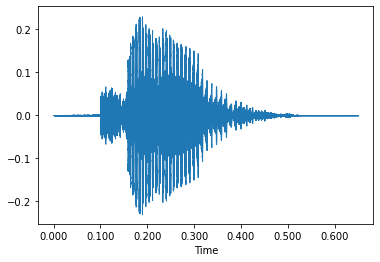

In [73]:
a = inference_to_audio(torch.tensor(samples[-1][2]))
ipd.Audio(a, rate= 22050)

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(samples[-1][13][0])
fig.colorbar(img, ax=ax)


In [ ]:
samples[-1][0][0].shape

## Noisy data 생성

In [ ]:
## Korean Speech
inference_data = torchaudio.load('kss_data/kss/4/4_5631.wav')[0] ## 학습 이외의 데이터
inference_resample_audio = torchaudio.functional.resample(inference_data, orig_freq=44100, new_freq=22050)
inference_mel= mel_spectrogram(inference_resample_audio[0][11025:32802+11025]) ## [1,80,128] 



In [ ]:
inference_resample_audio = torchaudio.functional.resample(dataset[1][0], orig_freq=48000, new_freq=22050)
inference_mel = mel_spectrogram(inference_resample_audio[0][11025:32802+11025]) #[11025:32802+11025]

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(inference_mel[0].numpy())
fig.colorbar(img, ax=ax)
a = inference_to_audio(inference_mel[0])
ipd.Audio(a, rate= 22050)


In [ ]:
nosiy_data = q_sample(inference_mel, torch.tensor([40]))
fig, ax = plt.subplots()
img = librosa.display.specshow(nosiy_data[0].numpy())
fig.colorbar(img, ax=ax)
a = inference_to_audio(nosiy_data[0])
ipd.Audio(a, rate= 22050)

In [ ]:
inference_mel.shape

In [ ]:
torch.randn(1,80,507).chunk(2,2)[0].shape

In [ ]:
inference_mel.chunk(2, 2)[1].shape
## 향후에 전체 음성으로 해보기
## 완전 가우시안 노이즈가 아닌 노이즈가 낀 이미지를 Enhancement 하는 것
## 전체 음성으로 하려면 노이즈가 낀 이미지를 나눠야함. 그 후 각각의 분할마다 for문을 돌려서 enhancement 시키고 나중에 합쳐서 생성
## 추론에 시간 엄청 걸릴듯
## 하나의 샘플이면 괜찮을지도

In [ ]:

# Algorithm 2 (including returning all images)
@torch.no_grad()
def Enhancement_p_sample_loop(model, shape, image, timesteps):
    device = next(model.parameters()).device
    
    timesteps = timesteps 

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = image.to(device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs



In [ ]:
result = Enhancement_p_sample_loop(model, shape = (1,1,80,128), image = nosiy_data.unsqueeze(0), timesteps= 50)

In [ ]:

fig, ax = plt.subplots()
img = librosa.display.specshow(result[-1][0][0])
fig.colorbar(img, ax=ax)
a = inference_to_audio(torch.tensor(result[-1][0]))
ipd.Audio(a, rate= 22050)

In [ ]:
result[-1][0].shape

In [ ]:
a= inference_to_audio(torch.tensor(samples[-1][7], device= device))
ipd.Audio(a, rate= 22050)